In [97]:
import xarray as xr
import numpy as np
import pandas as pd

import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline

In [98]:
#%config InlineBackend.close_figures=False # tell pyplot not to close figures
#np.warnings.filterwarnings('ignore') # silence numpy warning

In [99]:
# path to netcdf file
f = r'\\SFP.IDIR.BCGOV\U164\MLABIADH$\Profile\Desktop\TRAINING\RS\NetCDF\precip.comb.v2018to2016-v6monitorafter.total.nc'

In [100]:
# open netcdf file
ds = xr.open_dataset(f)
ds.dims

Frozen({'lat': 180, 'lon': 360, 'time': 1548})

In [101]:
# explore variables
ds.var

<bound method ImplementsDatasetReduce._reduce_method.<locals>.wrapped_func of <xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1548)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1891-01-01 1891-02-01 ... 2019-12-01
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    Original_Source:  http://www.dwd.de/en/FundE/Klima/KLIS/int/GPCC/GPCC.htm...
    Reference:        Users of the data sets are kindly requested to give fee...
    original_source:  ftp://ftp-anon.dwd.de/pub/data/gpcc/html/download_gate....
    Conventions:      CF 1.0
    dataset_title:    Global Precipitation Climatology Centre (GPCC)
    title:            GPCC Full Data Reanalysis Version 2018 1.0x1.0 Monthly ...
    history:          Created 09/2018  based on V2018 data obtained via ftp
    References:       https://www.psl.noaa.go

In [102]:
# ewxplore precipitation variable
prec = ds.precip
prec

<xarray.DataArray 'precip' (time: 1548, lat: 180, lon: 360)>
[100310400 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1891-01-01 1891-02-01 ... 2019-12-01
Attributes:
    long_name:     GPCC Monthly total of precipitation
    statistic:     Total
    valid_range:   [   0. 8000.]
    parent_stat:   Observations
    var_desc:      Precipitation
    units:         mm
    level:         Surface
    actual_range:  [   0.   3349.61]
    dataset:       GPCC Precipitation 1.0degree V2018 Full Reanalysis

In [103]:
# extract data for specific date
oct2018 = prec.sel(time='2018-10-01')

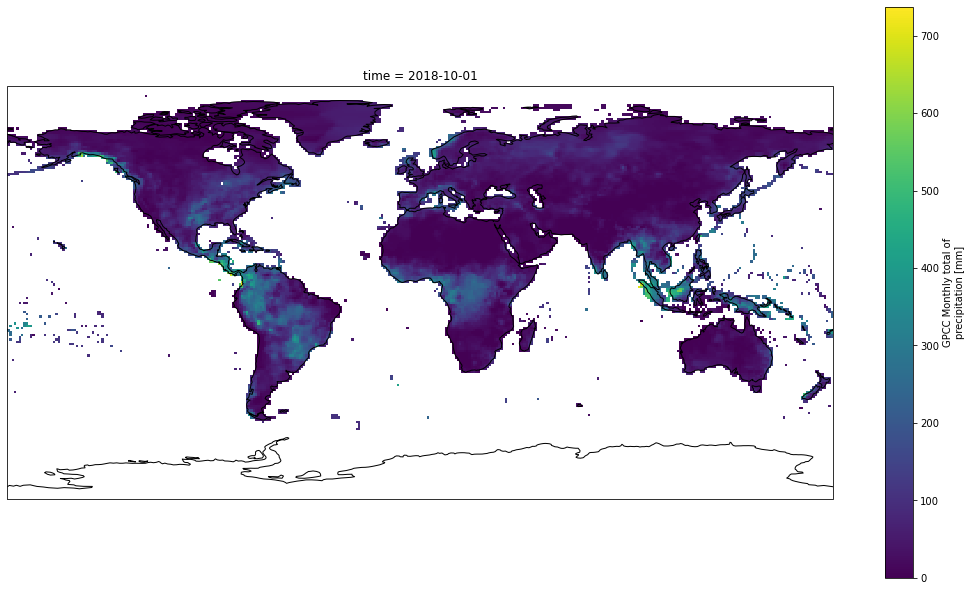

In [104]:
# plot data
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines() 
oct2018.plot()
plt.show()

In [136]:
# extract year and month precipitation for a specific location: vanocuver BC
prec_slice = prec.sel(time=slice("2010-01-01", "2019-12-31"))

pre_monthly_loc = prec_slice.sel(lat = 49, 
                           lon = -123+360, # add 360 to convert negative longs from (-180, 180) to (0, 360)
                           method='nearest')

df = pre_monthly_loc.to_dataframe()
df.reset_index(drop=False, inplace=True)
df = df[['time', 'precip']]
df['year'] = pd.DatetimeIndex(df['time']).year
df['Month'] = pd.DatetimeIndex(df['time']).month
df['month'] = pd.DatetimeIndex(df['time']).month_name().str.slice(stop=3)
df

,time,precip,year,Month,month
0,2010-01-01,312.390015,2010,1,Jan
1,2010-02-01,200.419998,2010,2,Feb
2,2010-03-01,205.570007,2010,3,Mar
3,2010-04-01,177.970001,2010,4,Apr
4,2010-05-01,131.910004,2010,5,May
...,...,...,...,...,...
115,2019-08-01,58.080002,2019,8,Aug
116,2019-09-01,189.190002,2019,9,Sep
117,2019-10-01,231.259995,2019,10,Oct
118,2019-11-01,186.910004,2019,11,Nov


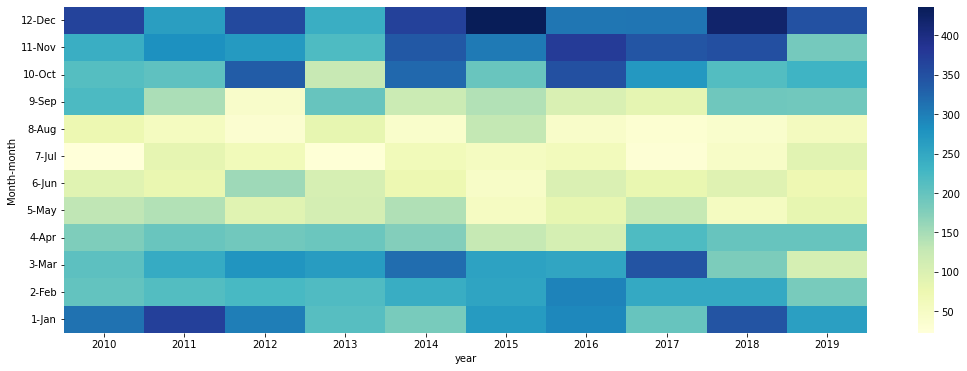

In [156]:
# Create a Heatmap for year/month precipitation in Vancouver, BC
data = df.pivot(["Month","month"], "year", "precip")

data = data.sort_values(by='Month',ascending=False)

fig = plt.gcf()
fig.set_size_inches(18, 6)

ax = sns.heatmap(data, cmap="YlGnBu")

In [9]:
# extract oct 2018 precipitation in British Columbia - this time using .where instead of .sel
bc_oct2018_prec = oct2018.where((oct2018.lat > 45) & 
                                (oct2018.lat < 70) & 
                                (oct2018.lon > -137+360) & # add 360 to convert negative longs from (-180, 180) to (0, 360)
                                (oct2018.lon < -114+360),
                                drop=True)

In [10]:
# export extracted data to dataframe
df = bc_oct2018_prec.to_dataframe()
df.tail()

time     precip
lat  lon                        
45.5 241.5 2018-10-01  56.549999
     242.5 2018-10-01  52.779999
     243.5 2018-10-01  51.759998
     244.5 2018-10-01  73.239998
     245.5 2018-10-01  47.490002

In [11]:
# calculate annual precpitation from monthly data
annual_prec = ds.groupby("time.year").sum("time")
annual_prec

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, year: 129)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * year     (year) int64 1891 1892 1893 1894 1895 ... 2015 2016 2017 2018 2019
Data variables:
    precip   (year, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

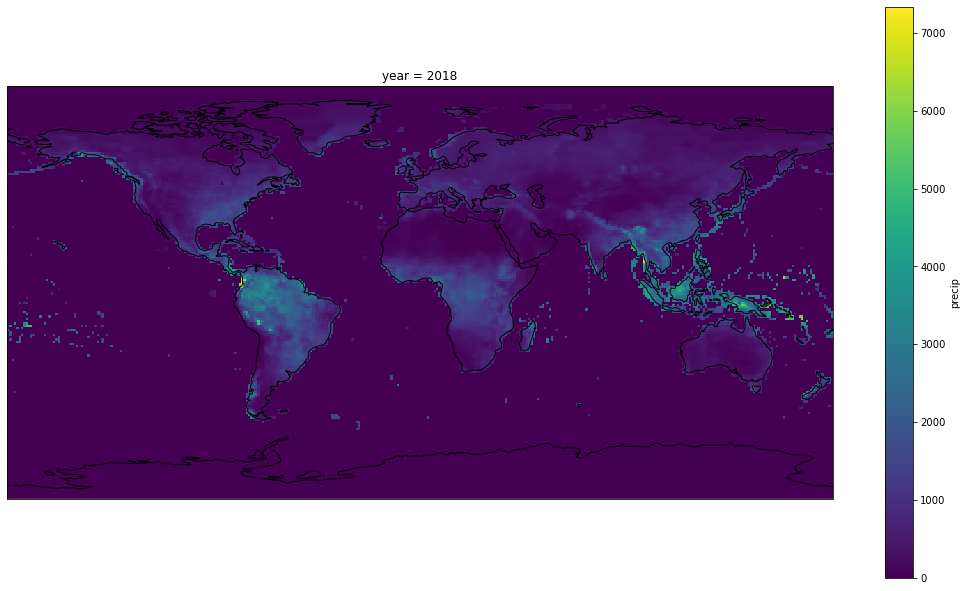

In [12]:
# plot annual precipitation for selected year: 2018
prec = annual_prec.precip
year2018 = prec.sel(year=2018)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines() 
year2018.plot()
plt.show()

In [13]:
# extract annual precipitation for a specific location: vanocuver BC
annual_prec_loc = annual_prec.sel(lat = 49, 
                                  lon = -123+360,
                                  year = [x for x in range(1990, 2020)],
                                  
                                   method='nearest')

annual_prec_loc

<xarray.Dataset>
Dimensions:  (year: 30)
Coordinates:
    lat      float32 49.5
    lon      float32 237.5
  * year     (year) int64 1990 1991 1992 1993 1994 ... 2015 2016 2017 2018 2019
Data variables:
    precip   (year) float32 2.743e+03 2.234e+03 2.12e+03 ... 2.381e+03 2.009e+03

<function matplotlib.pyplot.show(close=None, block=None)>

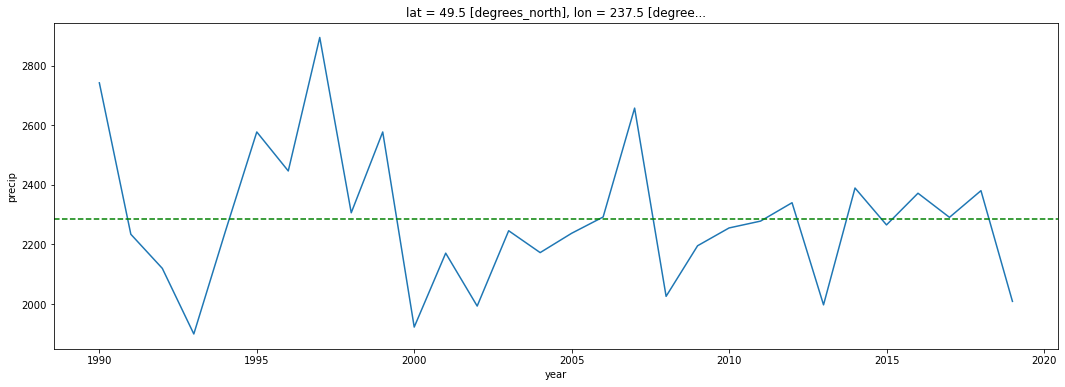

In [14]:

# plot results
annual_prec_loc.precip.plot()

mean_val = annual_prec_loc.mean('year')['precip']
plt.axhline (mean_val, color='g', linestyle='dashed') # plot the mean value

fig = plt.gcf()
fig.set_size_inches(18, 6)

plt.show


In [15]:
# calculate Annual Precipitation anomaly (z_score) for each year
mean = annual_prec.mean('year')['precip']
stdev = annual_prec.std('year')['precip']

annual_prec['z_score'] = (annual_prec.precip - mean) / stdev
annual_prec

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, year: 129)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * year     (year) int64 1891 1892 1893 1894 1895 ... 2015 2016 2017 2018 2019
Data variables:
    precip   (year, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    z_score  (year, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

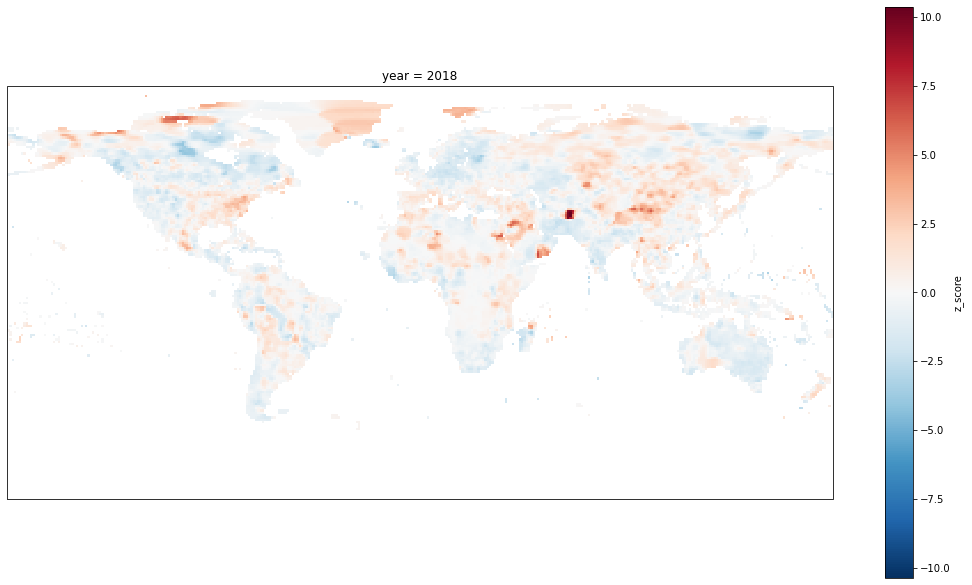

In [16]:
# plot the z_score for selected year: 2018
z_score = annual_prec.z_score
year2018 = z_score.sel(year=2018)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.axes(projection=ccrs.PlateCarree())
year2018.plot()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

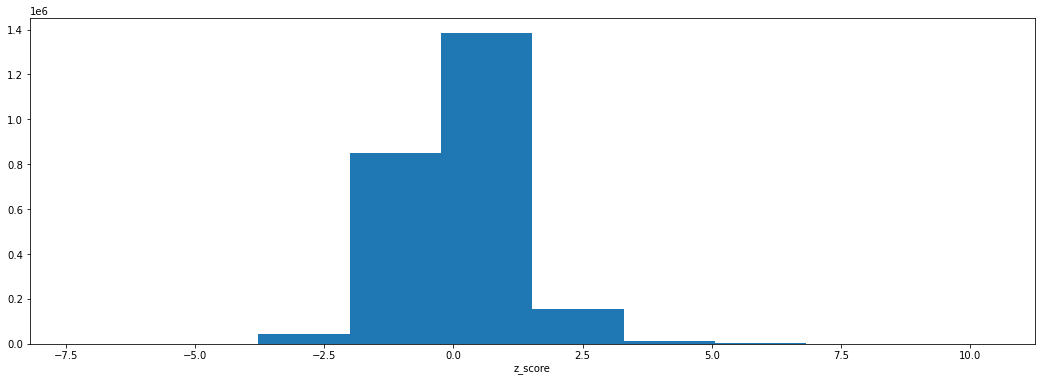

In [17]:
# Histogam of z_score
annual_prec.z_score.plot()

fig = plt.gcf()
fig.set_size_inches(18, 6)

plt.show

In [222]:
# save the new xarray dataset to netCDF
#output = r'\\SFP.IDIR.BCGOV\U164\MLABIADH$\Profile\Desktop\TRAINING\RS\NetCDF\precip_annual_anomalies.nc' 
#annual_prec.to_netcdf(path=output, mode='w')